Задание 1:  Используя ваши знания и опыт в области компьютерного зрения проведите следующий эксперимент:

1. Найдите фото любого известного актера или актрисы.
2. С помощью методов компьютерного зрения распознайте лицо на фотографии. Выделите лицо овалом. 
3. Распознайте на изображении глаза. Выделите их кружком. Нарисуйте вместо кружков солнцезащитные очки (картинку очков можно найти в интернете, задача их правильно масштабировать и разместить).
4. Все лицо кроме глаз необходимо "заблюрить" (размыть).

In [1]:
# !pip install mediapipe
# !pip install opencv-python

In [2]:
import numpy as np
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from dataclasses import dataclass

from glob import glob

import cv2
import matplotlib.pyplot as plt

In [3]:
base_options = python.BaseOptions(model_asset_path='detector.tflite')
options = vision.FaceDetectorOptions(base_options=base_options)
detector = vision.FaceDetector.create_from_options(options)

In [4]:
@dataclass
class FaceEllipse:
    center_coordinates: tuple | list
    axesLength: tuple | list
    angle: int

@dataclass
class EyeCircle:
    center_coordinates: tuple | list
    radius: int

@dataclass
class Face:
    orig_img: np.ndarray
    face_ellipse: FaceEllipse
    eye_circles: list[EyeCircle]
    blurred_face_img: np.ndarray = None

# 1. Считываем изображения

In [5]:
images = [mp.Image.create_from_file(img_path) for img_path in glob("images/faces/*.jpg")]

# 2. Распознаем лицо и глаза и рисуем

In [6]:
def recognise_face(image_numpy, detection, padding=0.15, eye_circle_radius = 40):
    img_height, img_width, _ = image_numpy.shape
    bbox = detection.bounding_box

    center_coordinates = bbox.origin_x + bbox.width // 2, bbox.origin_y + bbox.height // 2
    
    # уши - по ним ищем центр лица и полуширину элипса
    ear_keypoints = detection.keypoints[-2:]
    ek1, ek2 = ear_keypoints[0], ear_keypoints[1]
    ear_vector =  np.array(
        [(ek2.x - ek1.x) * img_width, 
        (ek2.y - ek1.y) * img_height],
        dtype=int
    )
    ear_vector_len = np.linalg.norm(ear_vector)
    center_coordinates = int((ek1.x + ek2.x) / 2 * img_width), int((ek1.y + ek2.y) / 2 * img_height)

    # рот-нос - по ним ищем угол наклона лица и полудлину элипса 
    # (исходя из априорных знаний золотого сечения и правила 1/3)
    mouth_keypoints = detection.keypoints[2:-2]
    mk1, mk2 = mouth_keypoints[0], mouth_keypoints[1]
    mouth_vector =  np.array(
        [(mk2.x - mk1.x) * img_width, 
        (mk2.y - mk1.y) * img_height],
        dtype=int
    )
    mouth_vector_len = np.linalg.norm(mouth_vector)
    angle = np.degrees(np.arccos(np.dot([1, 0], mouth_vector / mouth_vector_len)))

    axesLength = (int(mouth_vector_len * 3 * (1 + padding)), int(ear_vector_len / 2 * (1 + padding)))
    face_ellipse = FaceEllipse(center_coordinates, axesLength, angle)
    
    # image = cv2.ellipse(image, center_coordinates, axesLength, angle, 0, 360, color, thickness)
    # глаза
    eye_keypoints = detection.keypoints[:2]
    eye_circle = []
    for keypoint in eye_keypoints:
        center_coordinates = (int(keypoint.x * img_width), int(keypoint.y * img_height))
        
        eye_circle.append(EyeCircle(center_coordinates, eye_circle_radius))
        # cv2.circle(image, keypoint_px, radius, color, thickness)
    
    return Face(np.copy(image_numpy), face_ellipse, eye_circle)



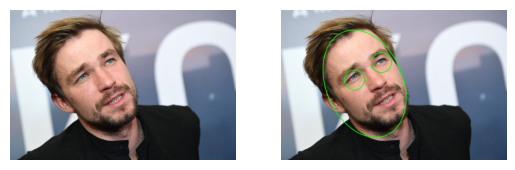

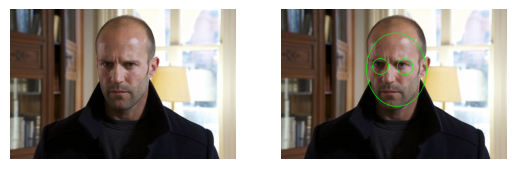

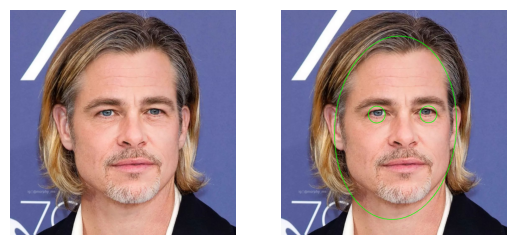

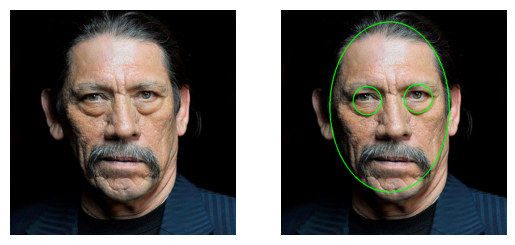

In [7]:
COLOR = (0, 255, 0)
THICKNESS = 2

FACES: list[Face] = []

for i, img in enumerate(images):
    detection_result = detector.detect(img)
    img_numpy = img.numpy_view().copy()

    # чтобы не усложнять код, предполагаем, что на изображении 1 лицо всегда, поэтому индекс 0
    detection = detection_result.detections[0]

    face = recognise_face(img_numpy, detection)
    FACES.append(face)

    face_ellipse = face.face_ellipse
    img_draw = cv2.ellipse(img_numpy, 
                            face_ellipse.center_coordinates, 
                            face_ellipse.axesLength, face_ellipse.angle, 0, 360, COLOR, THICKNESS)
    
    for eye_circle in face.eye_circles:
        img_numpy = cv2.circle(img_draw, eye_circle.center_coordinates, eye_circle.radius, COLOR, THICKNESS)


    _, axes = plt.subplots(nrows=1, ncols=2)
    axes[0].imshow(face.orig_img)
    axes[1].imshow(img_numpy)
    [ax.axis("off") for ax in axes]
    plt.show()

# 3. Блюрим лицо 
(по ряду причин решил, что именно этот шаг должен быть третьим, будет более показательно)

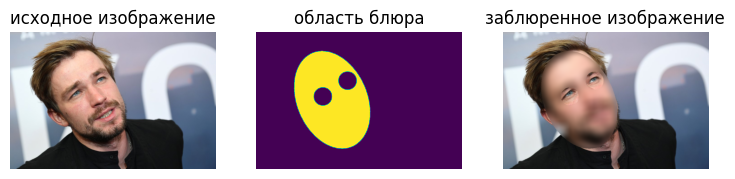

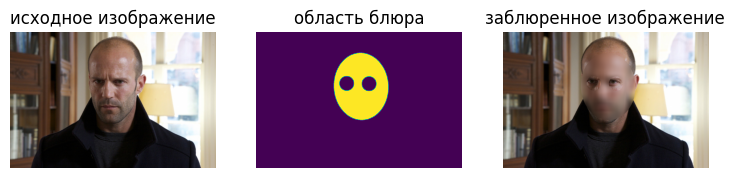

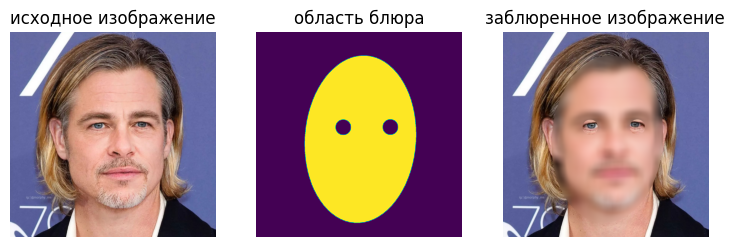

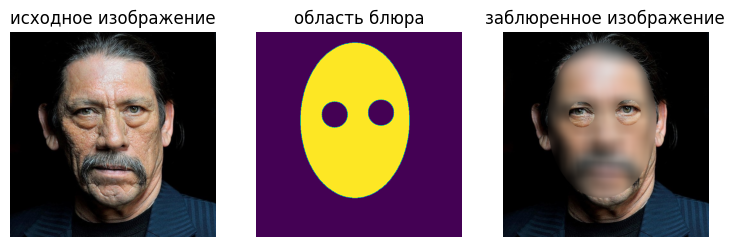

In [8]:
KERNEL_SIZE = 50

for face in FACES:
    img = np.copy(face.orig_img)

    # фиксируем область размытия
    face_mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    face_ellipse = face.face_ellipse
    face_mask = cv2.ellipse(face_mask, 
                            face_ellipse.center_coordinates, 
                            face_ellipse.axesLength, face_ellipse.angle, 0, 360, (255, 255, 255), -1)
    for eye_circle in face.eye_circles:
        face_mask = cv2.circle(face_mask, eye_circle.center_coordinates, eye_circle.radius, (0, 0, 0), -1)

    
    # размываем
    img_blurred = cv2.blur(img, (KERNEL_SIZE, KERNEL_SIZE), 0)
    img[face_mask>0] = img_blurred[face_mask>0]

    face.blurred_face_img = np.copy(img)


    _, axes = plt.subplots(figsize=(9, 3), nrows=1, ncols=3)
    axes[0].imshow(face.orig_img)
    axes[0].set_title("исходное изображение")
    axes[1].imshow(face_mask)
    axes[1].set_title("область блюра")
    axes[2].imshow(face.blurred_face_img)
    axes[2].set_title("заблюренное изображение")
    [ax.axis("off") for ax in axes]
    plt.show()

# 4. Рисуем очки

считываем изображение очков и их свойства (координаты центроидов линз)

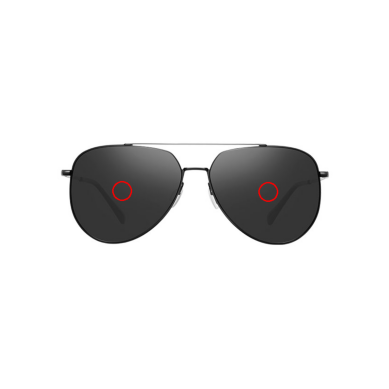

In [9]:
@dataclass
class GlassesCentroid:
    cx: int
    cy: int

@dataclass
class Glasses:
    glasses_img: np.ndarray
    glasses_img_binary: np.ndarray
    glasses_lens_centroids: list[GlassesCentroid]

glasses_img = cv2.imread("images/glasses.jpg")
glasses_gray = cv2.cvtColor(glasses_img, cv2.COLOR_BGR2GRAY)
glasses_img_binary = (glasses_gray < 254).astype(np.uint8) * 255 

dist_map = cv2.distanceTransform(glasses_img_binary, cv2.DIST_L2, cv2.DIST_MASK_5)
dist_map_bin = (cv2.normalize(dist_map, None, 0, 1.0, cv2.NORM_MINMAX) > 0.5).astype(np.uint8) * 255 

contours, _ = cv2.findContours(dist_map_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
glasses_lens_centroids: list[GlassesCentroid] = []
for contour in contours:
    M = cv2.moments(contour)
    if M['m00'] != 0:
        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])
        glasses_lens_centroids.append(GlassesCentroid(cx, cy))

# делаем бэкграунд черным
GLASSES = Glasses(glasses_img, glasses_img_binary, glasses_lens_centroids)

# дебаг
fig, ax = plt.subplots()
ax.axis("off")

glasses_img = np.copy(GLASSES.glasses_img)
for glasses_lens_centroid in GLASSES.glasses_lens_centroids:
    pos = (glasses_lens_centroid.cx, glasses_lens_centroid.cy)
    cv2.circle(glasses_img, pos, 20, (255, 0, 0), 2)
    
ax.imshow(glasses_img)

рисуем очки на лицах

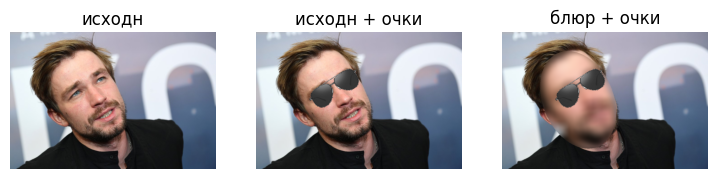

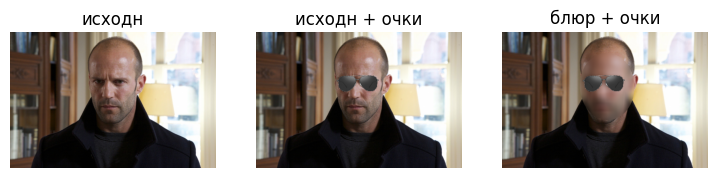

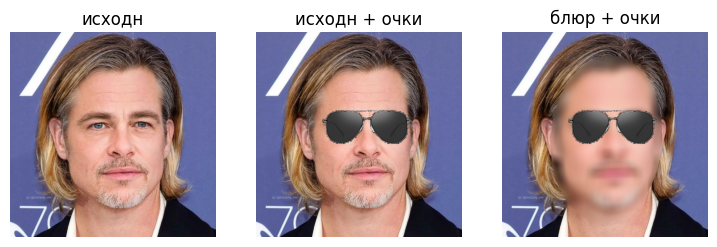

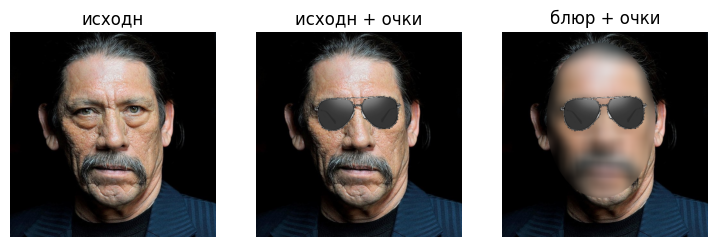

In [13]:
def get_vector_characteristics(start: tuple[int, int], end: tuple[int, int]):
    x1, y1 = start
    x2, y2 = end
    vector =  np.array([x2 - x1, y2 - y1], dtype=int)
    vector_len = np.linalg.norm(vector)
    vector_angle = np.degrees(np.arccos(np.dot([1, 0], vector / vector_len)))
    vector_center = (x1 + x2) // 2, (y1 + y2) // 2

    return vector_len, vector_angle, vector_center

def overlay_glasses_img(
    background_img,
    glasses_img,
    glasses_img_binary,
    eye_center_coords,
    angle,
    resize_coef
):

    # удаляем белый фон
    glasses_img_binary = cv2.merge([glasses_img_binary] * 3)
    glasses_img = cv2.bitwise_and(glasses_img, glasses_img_binary)
    
    # поворачиваем
    h, w, _ = glasses_img.shape
    M = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1)
    glasses_img = cv2.warpAffine(glasses_img, M, (w, h))

    # скейлим
    glasses_img = cv2.resize(glasses_img, (-1, -1), fx=resize_coef, fy=resize_coef)
    h, w, _ = glasses_img.shape

    # рисуем на лице
    cx, cy = eye_center_coords
    x1, y1 = cx - w // 2, cy - h // 2

    foreground_img = np.zeros(background_img.shape, dtype=np.uint8)
    foreground_img[y1:y1+h, x1:x1+w, :] = glasses_img

    foreground_mask = (cv2.cvtColor(foreground_img, cv2.COLOR_BGR2GRAY) > 0).astype(np.uint8)
    foreground_mask = cv2.merge([foreground_mask] * 3)
    
    return background_img * ~foreground_mask.astype(bool) + foreground_img


glasses_coords = [(c.cx, c.cy) for c in GLASSES.glasses_lens_centroids]
glasses_len, _, glasses_center = get_vector_characteristics(*glasses_coords)
glasses_img = np.copy(GLASSES.glasses_img)
glasses_img_binary = GLASSES.glasses_img_binary

for face in FACES:
    face_img = np.copy(face.orig_img)
    blurred_face_img = np.copy(face.blurred_face_img)

    eye_coords = [c.center_coordinates for c in face.eye_circles]
    eye_len, eye_angle, eye_center = get_vector_characteristics(*eye_coords)

    resize_coef = eye_len / glasses_len

    glasses_over_orig_img = overlay_glasses_img(
        face_img, 
        glasses_img, 
        glasses_img_binary, 
        eye_center,
        eye_angle,
        resize_coef
    )
    
    glasses_over_blurred_img = overlay_glasses_img(
        blurred_face_img, 
        glasses_img, 
        glasses_img_binary, 
        eye_center,
        eye_angle,
        resize_coef
    )


    _, axes = plt.subplots(figsize=(9, 3), nrows=1, ncols=3)
    axes[0].imshow(face_img)
    axes[0].set_title("исходн")
    axes[1].imshow(glasses_over_orig_img)
    axes[1].set_title("исходн + очки")
    axes[2].imshow(glasses_over_blurred_img)
    axes[2].set_title("блюр + очки")
    [ax.axis("off") for ax in axes]
    plt.show()